In [1]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib_venn import venn3
from matplotlib.patches import Patch

In [2]:
# Directory containing JSON files for each project
projects_directory = "../experiments/biomedical_projects_experiment/results/results/"

# List of import patterns to store DataFrames for each project
project_dfs_codedirs = []
project_dfs_deps = []
project_dfs_imports = []

# Iterate through JSON files in the directory
for filename in os.listdir(projects_directory):
    file_path = os.path.join(projects_directory, filename)

    # Load JSON data from the file
    with open(file_path, "r") as file:
        project_data = json.load(file)

    # Extract data from the project_data
    codedirs = project_data.get("code_dirs", {})
    deps_list = project_data.get("deps_file", [])
    imports_list = project_data.get("imports", [])

    # Create a list of dictionaries of code directories
    if codedirs:
        codedirs_dicts = [
            {
                "code directory": key,
                ".py count": value["py"],
                ".ipynb count": value["ipynb"],
                "count": value["total"],
            }
            for key, value in codedirs.items()
        ]
    else:
        codedirs_dicts = [
            {
                "code directory": None,
                ".py count": 0,
                ".ipynb count": 0,
                "count": 0,
            }
        ]

    # Create a DataFrame from the list of dictionaries
    codedirs_data = pd.DataFrame(codedirs_dicts)
    codedirs_data["project_name"] = project_data.get("project_name")

    # Append the DataFrame to the list
    project_dfs_codedirs.append(codedirs_data)

    # Create a list of dictionaries of dependency declaration files
    deps_dicts = [
        {
            "parser_choice": dep_data["parser_choice"],
            "path": dep_data["path"],
            "deps_count": dep_data["deps_count"],
            "warnings": dep_data["warnings"],
        }
        for dep_data in deps_list
    ]

    # Create a DataFrame from the list of dictionaries
    deps_data = pd.DataFrame(deps_dicts)
    deps_data["project_name"] = project_data.get("project_name")

    # Append the DataFrame to the list
    project_dfs_deps.append(deps_data)

    # Create a list of dictionaries of imports
    def _process_import_data(import_data):
        import_type = list(import_data.keys())[0]
        # Combine primary alternative and alternative imports into a single alternative import type
        display_import_type = import_type.removesuffix(" (primary)")
        import_dict = {
            "import_type": display_import_type,
            "name": import_data[import_type]["name"],
            "lineno": import_data[import_type]["source"]["lineno"],
        }
        return import_dict

    imports_dicts = [_process_import_data(import_data) for import_data in imports_list]

    # Create a DataFrame from the list of dictionaries
    imports_data = pd.DataFrame(imports_dicts)
    imports_data["project_name"] = project_data.get("project_name")

    # Append the DataFrame to the list
    project_dfs_imports.append(imports_data)

# Combine all project DataFrames into a single DataFrame
df_codedirs = pd.concat(project_dfs_codedirs, ignore_index=True)
df_deps = pd.concat(project_dfs_deps, ignore_index=True)
df_imports = pd.concat(project_dfs_imports, ignore_index=True)

# Code directories

In [3]:
df_codedirs_max = df_codedirs.loc[
    df_codedirs.groupby("project_name")["count"].idxmax()
].dropna()

In [4]:
df_codedirs_max

,code directory,.py count,.ipynb count,count,project_name
19,pilot,0,3,3,70S-resolution
26,scripts,8,0,8,CORD-19-on-FHIR
118,script_interactive-heatmap,0,1,1,CVB3_Capsid_DMS
73,DEERPREdict,6,0,6,DEERpredict
180,notebook,0,10,10,DIscBIO
...,...,...,...,...,...
59,notebooks,0,8,8,supFunSim
173,Library_design,0,2,2,titratableCRISPRi
163,uditas,5,0,5,uditas
116,scripts,2,0,2,vcflib


In [5]:
# Divide projects into three groups by code directory patterns
same_name_projects = df_codedirs_max[
    df_codedirs_max["code directory"] == df_codedirs_max["project_name"]
]["project_name"].tolist()

src_projects = df_codedirs_max[df_codedirs_max["code directory"].str.startswith("src")][
    "project_name"
].tolist()

rest_projects = df_codedirs_max[
    ~df_codedirs_max["project_name"].isin(same_name_projects + src_projects)
]["project_name"].tolist()

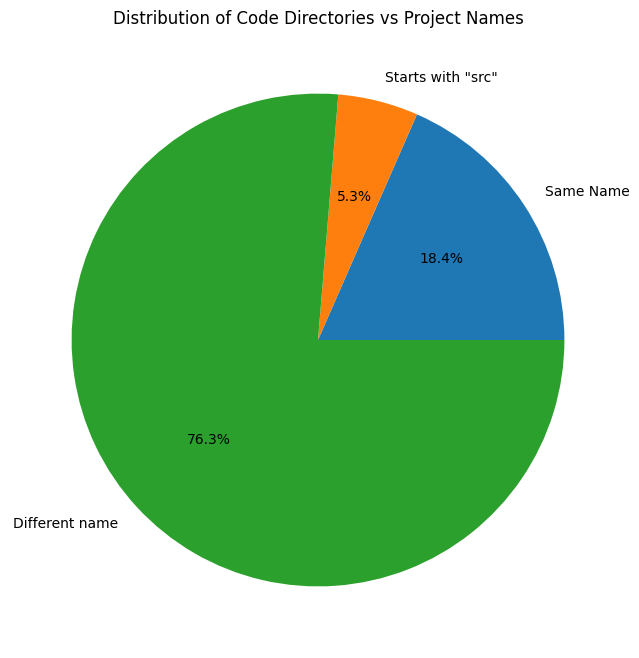

In [6]:
# Create a DataFrame for plotting
plot_data = pd.DataFrame(
    {
        "Category": ["Same Name", 'Starts with "src"', "Different name"],
        "Percentage": [len(same_name_projects), len(src_projects), len(rest_projects)],
        "Projects": [same_name_projects, src_projects, rest_projects],
    }
)

# Plotting as a pie chart
plt.figure(figsize=(8, 8))
plt.pie(
    plot_data["Percentage"],
    labels=plot_data.apply(lambda x: f"{x['Category']}", axis=1),
    # labels=plot_data.apply(lambda x: f"{x['Category']}:\n{x['Projects']}", axis=1),
    autopct="%1.1f%%",
)
plt.title("Distribution of Code Directories vs Project Names")
plt.show()

# Dependency declaration files

In [7]:
df_deps

,parser_choice,path,deps_count,warnings,project_name
0,setup.py,setup.py,0.0,True,darkflow
1,requirements.txt,test/requirements-testing.txt,8.0,False,darkflow
2,setup.py,setup.py,5.0,False,enzo
3,requirements.txt,docs/requirements.txt,4.0,False,MaBoSS_test
4,setup.py,setup.py,1.0,False,MaBoSS_test
...,...,...,...,...,...
98,setup.py,setup.py,0.0,True,openmmtools
99,setup.cfg,setup.cfg,0.0,False,openmmtools
100,setup.cfg,setup.cfg,0.0,False,louvain-igraph
101,setup.py,setup.py,0.0,True,louvain-igraph


In [8]:
# Divide projects into three groups by parser choice
project_req_txt = set(
    df_deps[df_deps["parser_choice"] == "requirements.txt"].loc[
        df_deps["deps_count"] > 0
    ]["project_name"]
)
project_pyproject_toml = set(
    df_deps[df_deps["parser_choice"] == "pyproject.toml"].loc[
        df_deps["deps_count"] > 0
    ]["project_name"]
)
project_setup = set(
    df_deps[df_deps["parser_choice"].str.startswith("setup")]["project_name"]
)

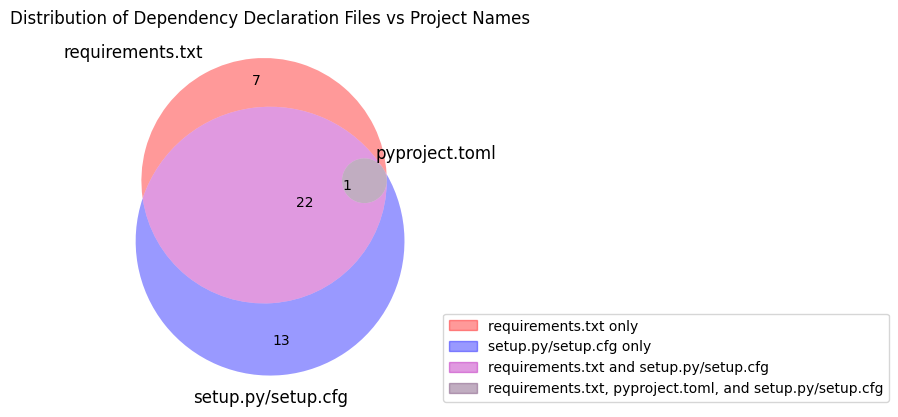

In [9]:
# Draw a venn diagram
plt.figure()
ax = plt.gca()

set_1_name = "requirements.txt"
set_2_name = "pyproject.toml"
set_3_name = "setup.py/setup.cfg"

venn_parsers = venn3(
    [project_req_txt, project_pyproject_toml, project_setup],
    set_labels=(set_1_name, set_2_name, set_3_name),
    ax=ax,
)

# Define labels for all sets and intersections
# for a 3-circle diagram, the sequence is 100, 010, 110, 001, 101, 011, 111
legend_labels = [
    f"{set_1_name} only",
    f"{set_2_name} only",
    f"{set_1_name} and {set_2_name}",
    f"{set_3_name} only",
    f"{set_1_name} and {set_3_name}",
    f"{set_2_name} and {set_3_name}",
    f"{set_1_name}, {set_2_name}, and {set_3_name}",
]

legend_handles = [
    Patch(
        color=patch.get_facecolor(),
        label=legend_labels[venn_parsers.patches.index(patch)],
    )
    for patch in venn_parsers.patches
    if patch
]

plt.legend(handles=legend_handles, loc=(1.04, 0))
plt.title("Distribution of Dependency Declaration Files vs Project Names")
plt.show()

# Import patterns

In [10]:
df_imports.head()

,project_name,import_type,name,lineno
0,NeuroM,Docstring,numpy,29.0
1,pyrodigal,Alternative imports,isal,28.0
2,MAGIC,Docstring,pandas,29.0
3,MAGIC,Docstring,matplotlib,29.0
4,pinsoro-kinematics-study,Docstring,pandas,23.0


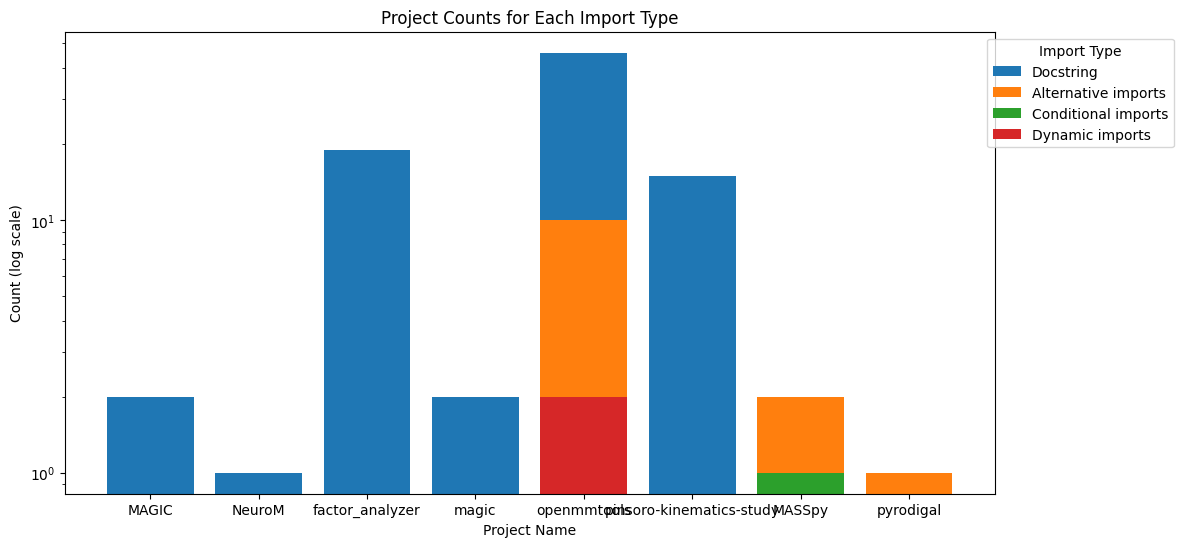

In [11]:
# Create a bar plot for the counts of each import type
plt.figure(figsize=(12, 6))

# Iterate over unique import types and plot a bar for each
for import_type in df_imports["import_type"].unique():
    import_type_data = df_imports[df_imports["import_type"] == import_type]
    project_counts = import_type_data.groupby("project_name").size()
    plt.bar(project_counts.index, project_counts, label=import_type)
    plt.yscale("log")  # Apply log scale to the y-axis for the plot
    plt.ylabel("Count (log scale)")
    plt.title("Project Counts for Each Import Type")
    plt.legend(title="Import Type", loc="upper right", bbox_to_anchor=(1.2, 1))

# Set the common x-axis label
plt.xlabel("Project Name")

plt.show()

In [12]:
# Divide projects into three groups by parser choice
project_conditional_imports = set(
    df_imports[df_imports["import_type"] == "Conditional imports"]["project_name"]
)
project_alternative_imports = set(
    df_imports[df_imports["import_type"] == "Alternative imports"]["project_name"]
)
project_dynamic_imports = set(
    df_imports[df_imports["import_type"] == "Dynamic imports"]["project_name"]
)
project_docstring = set(
    df_imports[df_imports["import_type"] == "Docstring"]["project_name"]
)
project_all = set(df_codedirs["project_name"])

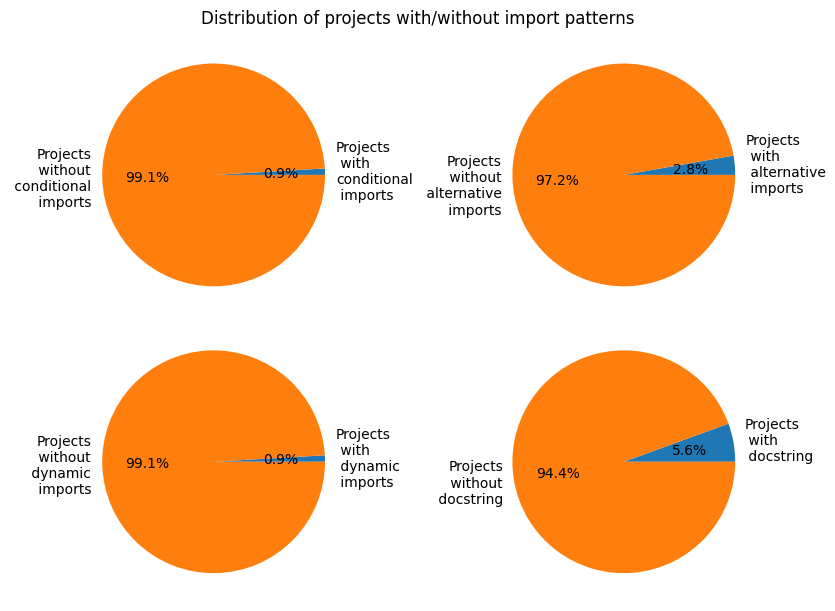

In [13]:
figure, axis = plt.subplots(2, 2, figsize=(9, 6), layout="compressed")

# Create a DataFrame for plotting
plot_data = pd.DataFrame(
    {
        "Category": [
            "Projects\n with \nconditional\n imports",
            "Projects\n without\n conditional\n imports",
        ],
        "Percentage": [
            len(project_conditional_imports),
            len(project_all) - len(project_conditional_imports),
        ],
    }
)

axis[0, 0].pie(
    plot_data["Percentage"],
    labels=plot_data.apply(lambda x: f"{x['Category']}", axis=1),
    autopct="%1.1f%%",
)

plot_data = pd.DataFrame(
    {
        "Category": [
            "Projects\n with\n alternative\n imports",
            "Projects\n without\n alternative\n imports",
        ],
        "Percentage": [
            len(project_alternative_imports),
            len(project_all) - len(project_alternative_imports),
        ],
    }
)

# Plotting as a pie chart
axis[0, 1].pie(
    plot_data["Percentage"],
    labels=plot_data.apply(lambda x: f"{x['Category']}", axis=1),
    autopct="%1.1f%%",
)


plot_data = pd.DataFrame(
    {
        "Category": [
            "Projects\n with\n dynamic\n imports",
            "Projects\n without\n dynamic\n imports",
        ],
        "Percentage": [
            len(project_dynamic_imports),
            len(project_all) - len(project_dynamic_imports),
        ],
    }
)

# Plotting as a pie chart
axis[1, 0].pie(
    plot_data["Percentage"],
    labels=plot_data.apply(lambda x: f"{x['Category']}", axis=1),
    autopct="%1.1f%%",
)

plot_data = pd.DataFrame(
    {
        "Category": ["Projects\n with\n docstring", "Projects\n without\n docstring"],
        "Percentage": [
            len(project_docstring),
            len(project_all) - len(project_docstring),
        ],
    }
)

# Plotting as a pie chart
axis[1, 1].pie(
    plot_data["Percentage"],
    labels=plot_data.apply(lambda x: f"{x['Category']}", axis=1),
    autopct="%1.1f%%",
)

plt.suptitle("Distribution of projects with/without import patterns")
plt.show()